In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import torchtext
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import random
import pandas as pd

debug = False

print("Pytorch: \t\t", torch.__version__)
if not debug and torch.cuda.is_available():
    device='cuda'
    print('GPU:         \t\t', torch.cuda.get_device_name(0))
    print('Memory Usage:\t',
        round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB / ',
        round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    torch.backends.cudnn.benchmark = True
else:
    print("GPU is **not available**")
    device='cpu'

Pytorch: 		 1.10.2+cu102
GPU:         		 NVIDIA GeForce GTX 1660 Ti
Memory Usage:	 0.0 GB /  0.0 GB


In [2]:
# Initializing parameters

batch_size = 32     # Reduce this if you get memory errors

seed = 2476          # A random seed to get replicable results

sequence_max_length = 250

vocab_size = 10000

In [3]:
data_dir = pathlib.Path('/home/addy/datasets/aclImdb_v1/')

if data_dir.exists():
    print("Found the 'aclImdb_v1' dataset.")
else:
    print("Downloading the 'aclImdb_v1' dataset.")
    dataset_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    !wget {dataset_url} -P {data_dir.parent}
    !mkdir {data_dir}
    !tar xf {data_dir.parent / "aclImdb_v1.tar.gz"} -C {data_dir}
    !mv {data_dir / 'train' / 'unsup'} {data_dir / 'unsup'}
data_dir = data_dir / 'aclImdb'


Found the 'aclImdb_v1' dataset.


In [4]:
class DFDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        res = list(self.df.iloc[index])
        res.append(index)
        return res

    def add_new_df(self, new_df):
        self.df = self.df.append(new_df, ignore_index=True)

In [5]:
def cleanup(data):
    return data.replace('<br />', '')

test_dir = data_dir / 'test'

files = [y for y in (test_dir).glob('*/*')] 
random.shuffle(files)

num_test = len(files)//2
testdata = [(i.parent.stem, cleanup(open(i).read())) for i in files[:num_test]]

oracledata = [(i.parent.stem, cleanup(open(i).read())) for i in files[num_test:]]
oracledata += [(i.parent.stem, cleanup(open(i).read())) for i in files]

train_dir = data_dir / 'train'

files = [y for y in (train_dir).glob('*/*')] 

testdf = pd.DataFrame(testdata, columns =['cat', 'text'])
traindf = pd.DataFrame([], columns =['cat', 'text'])
oracledf = pd.DataFrame(oracledata, columns =['cat', 'text'])

print(len(traindf))
print()
print(tuple(testdf.iloc[0]))
print()
print(tuple(oracledf.iloc[0]))
print()
len(traindf), len(testdf), len(oracledf)

0

('neg', 'This is one of those so-called "Hollywood Social Commentary" films that wants to have it both ways. And believe me, in this film, both ways are clichéd and stereotypical. STOP-LOSS is a 21st Century John Wayne Film dealing with some anti-war sentiment but clearly ending on the note that "If you are a MAN in today\'s society, you get your act together and march off to war with your buddies." In many ways the film was a great sequel to TAXI TO THE DARK SIDE as it portrayed a military equally as insane and out of control, a quasi FRAT PARTY/ANIMAL HOUSE extravaganza mixed in with a Texas Red Neck world of repressed homo-erotic proofs of masculinity. This movie had it all in one scene after another of clichéd imagery. And then rebellious military deserter Ryan Phillippe goes on a "Road Trip" with best friend\'s girlfriend, an artificial storyline manipulation to visit families of dead servicemen, maimed soldiers in military hospitals, etc. and finally to broach the issue of fle

(0, 12500, 37500)

In [6]:
train_dataset = DFDataset(traindf)
test_dataset = DFDataset(testdf)
oracle_dataset = DFDataset(oracledf)


In [7]:
from collections import Counter, OrderedDict

def build_vocab_from_iterator(iterator, min_freq: int = 1, specials = [], special_first: bool = True, vocab_size = None):
    counter = Counter()
    for tokens in iterator:
        counter.update(tokens)

    if specials is not None:
        for tok in specials:
            del counter[tok]

    sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[0])
    sorted_by_freq_tuples.sort(key=lambda x: x[1], reverse=True)
    
    if vocab_size is not None:
        sorted_by_freq_tuples = sorted_by_freq_tuples[:vocab_size]

    ordered_dict = OrderedDict(sorted_by_freq_tuples)

    if specials is not None:
        if special_first:
            specials = specials[::-1]
        for symbol in specials:
            ordered_dict.update({symbol: min_freq})
            ordered_dict.move_to_end(symbol, last=not special_first)

    word_vocab = torchtext.vocab.vocab(ordered_dict, min_freq=min_freq)
    return word_vocab


In [8]:
def collate_batch(batch):
     label_list, text_list, idx_list = [], [], []
     for (label, text, idx) in batch:
          input = text_pipeline(text)
          label_list.append(torch.tensor([label_pipeline(label)], dtype=torch.float32))
          
          a = torch.tensor(input[:sequence_max_length], dtype=torch.int64)
          b = torch.zeros(max(0, sequence_max_length - len(input)), dtype=torch.int64)
          text_list.append(torch.cat((a,b)))

          idx_list.append(idx)
               
     label_list = torch.stack(label_list)
     text_list = torch.stack(text_list)
     return text_list, label_list, idx_list

In [9]:
'''
Each query strategy below returns a list of len=query_size with indices of 
samples that are to be queried.

Arguments:
- model (torch.nn.Module): not needed for `random_query`
- device (torch.device): not needed for `random_query`
- dataloader (torch.utils.data.DataLoader)
- query_size (int): number of samples to be queried for labels (default=10)

'''
def random_query(data_loader, query_size=10):
    
    sample_idx = []
    
    # Because the data has already been shuffled inside the data loader,
    # we can simply return the `query_size` first samples from it
    for batch in data_loader:
        
        _, _, idx = batch
        if type(idx) == list:
            sample_idx.extend(idx)
        else:
            sample_idx.extend(idx.tolist())

        if len(sample_idx) >= query_size:
            break
    
    return sample_idx[0:query_size]

def binary_least_confidence_query(model, device, data_loader, query_size=10):
    confidences = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for X, _, idx in data_loader:
            X = X.to(device)
            probabilities = model(X)
            confidence = (torch.abs(probabilities - 0.5)*2).squeeze(dim=-1)
            
            confidences.extend(confidence.cpu().tolist())
            indices.extend(idx)
            
    conf = np.asarray(confidences)
    ind = np.asarray(indices)
    sorted_pool = np.argsort(conf)
    # Return the indices corresponding to the lowest `query_size` confidences
    return ind[sorted_pool][0:query_size]

# def least_confidence_query(model, device, data_loader, query_size=10):

#     confidences = []
#     indices = []
    
#     model.eval()
    
#     with torch.no_grad():
#         for batch in data_loader:
        
#             data, _, idx = batch
#             logits = model(data.to(device))
#             probabilities = F.softmax(logits, dim=1)
            
#             # Keep only the top class confidence for each sample
#             most_probable = torch.max(probabilities, dim=1)[0]
#             confidences.extend(most_probable.cpu().tolist())
#             indices.extend(idx.tolist())
            
#     conf = np.asarray(confidences)
#     ind = np.asarray(indices)
#     sorted_pool = np.argsort(conf)
#     # Return the indices corresponding to the lowest `query_size` confidences
#     return ind[sorted_pool][0:query_size]

# def margin_query(model, device, data_loader, query_size=10):
    
#     margins = []
#     indices = []
    
#     model.eval()
    
#     with torch.no_grad():
#         for batch in data_loader:
        
#             data, _, idx = batch
#             logits = model(data.to(device))
#             probabilities = F.softmax(logits, dim=1)
            
#             # Select the top two class confidences for each sample
#             toptwo = torch.topk(probabilities, 2, dim=1)[0]
            
#             # Compute the margins = differences between the two top confidences
#             differences = toptwo[:,0]-toptwo[:,1]
#             margins.extend(torch.abs(differences).cpu().tolist())
#             indices.extend(idx.tolist())

#     margin = np.asarray(margins)
#     index = np.asarray(indices)
#     sorted_pool = np.argsort(margin)
#     # Return the indices corresponding to the lowest `query_size` margins
#     return index[sorted_pool][0:query_size]


In [10]:
# def query_the_oracle(model, device, dataset, query_size=10, query_strategy='random', 
#                      interactive=False, pool_size=0, num_workers=4):
#     if pool_size > 0:    
#         sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=pool_size)
#         pool_loader = DataLoader(dataset, sampler=sampler, batch_size=batch_size, num_workers=num_workers)
#     else:
#         pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
        
#     if query_strategy == 'margin':
#         sample_idx = margin_query(model, device, pool_loader, query_size)
#     elif query_strategy == 'least_confidence':
#         sample_idx = least_confidence_query(model, device, pool_loader, query_size)
#     else:
#         sample_idx = random_query(pool_loader, query_size)

#     # Query the samples, one at a time
#     # for sample in sample_idx:
#     #     if interactive:
#             # dataset.display(sample)
#             # print("What is the class of this image?")
#             # new_label = int(input())
#             # dataset.update_label(sample, new_label)

#     res = dataset.df.iloc[sample_idx]
#     dataset.df.drop(dataset.df.iloc[sample_idx].index, inplace=True)
#     return res

def query_the_binary_oracle(model, device, dataset, query_size=10, query_strategy='random', 
                     interactive=False, pool_size=0, num_workers=8):
    collate_function = None
    if model is not None:
        collate_function = collate_batch
    if pool_size > 0:    
        sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=pool_size)
        pool_loader = DataLoader(dataset, sampler=sampler, batch_size=batch_size, num_workers=num_workers, collate_fn=collate_function)
    else:
        pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, collate_fn=collate_function)

    res2 = None
        
    if query_strategy == 'least_confidence':
        sample_idx = binary_least_confidence_query(model, device, pool_loader, query_size)
    elif query_strategy == 'split':
        half = query_size//2
        sample_idx = binary_least_confidence_query(model, device, pool_loader, half)

        res2 = dataset.df.iloc[sample_idx]
        dataset.df.drop(dataset.df.iloc[sample_idx].index, inplace=True)

        if pool_size > 0:    
            sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=pool_size)
            pool_loader = DataLoader(dataset, sampler=sampler, batch_size=batch_size, num_workers=num_workers, collate_fn=collate_function)
        else:
            pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, collate_fn=collate_function)

        sample_idx += random_query(pool_loader, query_size, query_size - half)
    else:
        sample_idx = random_query(pool_loader, query_size)

    # Query the samples, one at a time
    # for sample in sample_idx:
    #     if interactive:
            # dataset.display(sample)
            # print("What is the class of this image?")
            # new_label = int(input())
            # dataset.update_label(sample, new_label)
    res = dataset.df.iloc[sample_idx]
    if res2 != None:
        res = res.append(res2)
    
    dataset.df.drop(dataset.df.iloc[sample_idx].index, inplace=True)
    return res

In [11]:
splits = {
    0: 4500,
    10: 4000,
    20: 4000
}

new_datapoints = query_the_binary_oracle(None, device, oracle_dataset, splits[0])
train_dataset.add_new_df(new_datapoints)

In [12]:
len(train_dataset.df)

4500

In [13]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text, _ in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<pad>", "<unk>"], vocab_size=10000-2)
vocab.set_default_index(vocab["<unk>"])

pad_id = vocab['<pad>']

In [14]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == 'pos' else 0

In [15]:
pad_id, len(vocab)

(0, 10000)

In [16]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    num_workers=8,
    batch_size=batch_size,
    collate_fn=collate_batch)

test_dataloader = DataLoader(
    test_dataset, 
    num_workers=8,
    batch_size=batch_size, 
    collate_fn=collate_batch)


In [17]:

for X, y, idx in train_dataloader:
    print("Shape of X: ", X.shape)
    print("Labels : ", y.shape)
    print("SAMPLE")
    print("Label: ",y[0].item())
    print("Index:", idx[0])
    print("Text:")
    print(" ".join(vocab.lookup_tokens(X[0].tolist())))
    # print(X, y, o)
    break

Shape of X:  torch.Size([32, 250])
Labels :  torch.Size([32, 1])
SAMPLE
Label:  0.0
Index: 1823
Text:
calling this film a decent or enjoyable horror tribute is far too optimistic . heck , you can ' t even refer to it as a nice spoof of the genre because it ' s way below average ( it ' s funny , but not <unk> , you know ) . but still i ' d say to give it a look . if only for the huge amount of trivia elements in it . by the way , all those people who ' re complaining about this movie here in their comments have only themselves to blame . when you see the <unk> of this film , you should already know that it ' s not going to be on the same level as the piano for example , so don ' t come complaining afterwards . . . evil ed could ' ve been something but the totally screwed it up . i suppose the main idea behind this film is criticism towards the growing ' <unk> ' in horror nowadays . it shows an editor named edward who ' s slowly ( well , not too slowly ) going nuts by seeing all the viol

In [18]:
from torch import nn

class ClassifyNet(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim)
        # self.pool = nn.AvgPool1d(3, stride=2)
        self.fc = nn.Linear(embed_dim, num_class)
        self.dropout = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.emb(x)
        # print(x.shape)
        x = self.dropout(x)
        x = torch.mean(x, 1)
        x = self.dropout2(x)
        # print(x.shape)
        x = self.fc(x)

        return torch.sigmoid(x)

In [19]:
a = torch.randn(32, 250, 16)
torch.mean(a, 1).shape

torch.Size([32, 16])

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader.dataset)
    total_loss, accuracy = 0, 0
    for batch, (X, y, _) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        #FORWARD PASS
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    accuracy /= size
    total_loss /= size
    history['train_loss'].append(total_loss)
    history['train_accuracy'].append(accuracy)
    return loss, accuracy


def test_loop(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        for X, y, _ in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            
            loss += loss_fn(pred, y).item()
            accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy /= size

    history['test_loss'].append(loss)
    history['test_accuracy'].append(accuracy)
    return loss, accuracy

In [21]:
emsize = 16
num_classes = 1
vocab_size = len(vocab)

model = ClassifyNet(vocab_size, emsize, num_classes).to(device)
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)



In [22]:
count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {count}")

Number of trainable parameters: 160017


In [23]:
epochs = 50
history = {
    'train_loss':[],
    'train_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
    if t > 0 and t in splits:
        new_datapoints = query_the_binary_oracle(model, device, oracle_dataset, query_size=splits[t], query_strategy='least_confidence')
        train_dataset.add_new_df(new_datapoints)
        train_dataloader = DataLoader(
            train_dataset,
            shuffle=True,
            num_workers=8,
            batch_size=batch_size,
            collate_fn=collate_batch)
            
    train_loop(train_dataloader, model, loss_fn, optimizer, history)
    test_loop(test_dataloader, model, loss_fn, history)

01:50 Elapsed | 100% done |██████████| 50/50 [00:00 remaining |  2.20s/epoch]


In [24]:
len(train_dataset)

12500

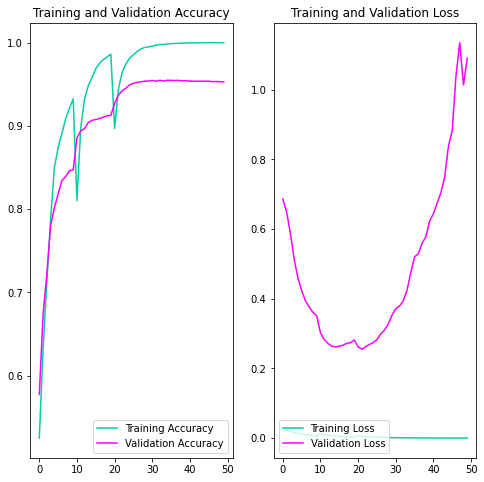

In [25]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='#03CEA4')
plt.plot(epochs_range, history['test_accuracy'], label='Validation Accuracy', color='#fc00ff')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='#03CEA4')
plt.plot(epochs_range, history['test_loss'], label='Validation Loss', color='#fc00ff')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()


In [26]:
max(history['test_accuracy'])

0.9548